In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pri = np.ones(10) * 0.25

pri

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [3]:
MAX_WIDTH, MAX_HEIGHT = 24, 24


In [4]:
# select 3 and observe of a 1

from scipy.ndimage import maximum_filter

MIN_PROB = 0.001
PRIORI = 0.25

class HiddenRelicNodeEstimator:

    def __init__(self):
        self.priori = np.zeros((MAX_WIDTH, MAX_HEIGHT))
        self.relic_positions = set()

    def update(self, is_relic_neighbour, unit_positions, new_team_points):
        is_relic_nb = (is_relic_neighbour == 1)
        self.priori[is_relic_nb & (self.priori == 0)] = PRIORI

        obs = np.argwhere((is_relic_neighbour == 1) & unit_positions)
        post = self.calc_posteriori_probs(obs, new_team_points)
        self.priori[is_relic_nb] = np.clip(post[is_relic_nb], MIN_PROB, 0.999) 
        
    def calculate_p_data(self, obs, n, p):
        if n < 0:
            return 0
            
        m = len(obs)
        
        # represent the probability of observe k team points from the first j locations.
        dp = np.zeros((m+1, n+1))  
        dp[0][0] = 1
        
        for j in range(1, m+1):
            pos = obs[j-1]
            pj = p[pos[0]][pos[1]]
            for k in range(n+1):
                dp[j][k] += dp[j-1][k] * (1 - pj)
                if k > 0:
                    dp[j][k] += dp[j-1][k-1] * pj
        return dp[m][n]

    def calc_posteriori_probs(self, observed_cells, new_team_points):
        m = len(observed_cells)
        n = min(new_team_points, m)
        
        p_data = self.calculate_p_data(observed_cells, n, self.priori)
        assert p_data > 0
        print(f'p_data = {p_data}')
        
        post = self.priori.copy()
        for i in observed_cells:
            x, y = i
            ob_exclude = [c for c in observed_cells if not (c[0] == x and c[1] == y)]
            print(ob_exclude)
            p_data_given_i = self.calculate_p_data(ob_exclude, n - 1, self.priori)
            post[x][y] = p_data_given_i * self.priori[x][y] / p_data
            print(f"post[{x}][{y}] = {post[x][y]}, self.priori[x][y]={self.priori[x][y]}, p_data_given_i={p_data_given_i}")
        return post

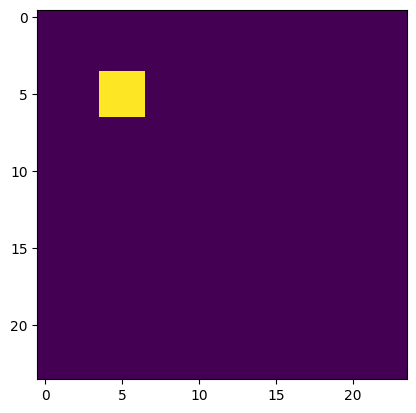

In [5]:
mask = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)

mask[5][5] = 1
mask = maximum_filter(mask, size=3)

plt.imshow(mask);

In [6]:
np.argwhere(mask)

array([[4, 4],
       [4, 5],
       [4, 6],
       [5, 4],
       [5, 5],
       [5, 6],
       [6, 4],
       [6, 5],
       [6, 6]])

p_data = 0.75
[]
post[4][4] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0


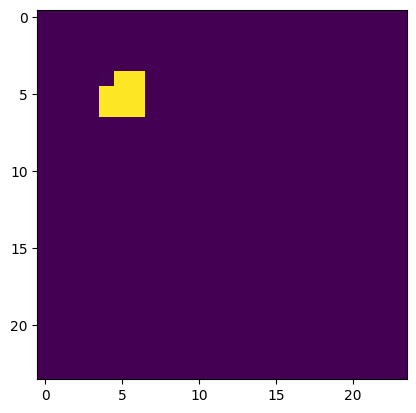

In [7]:
# units position has no TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 0)

plt.imshow(relic_estimator.priori)

p_data = 0.25
[]
post[4][4] = 1.0, self.priori[x][y]=0.25, p_data_given_i=1.0


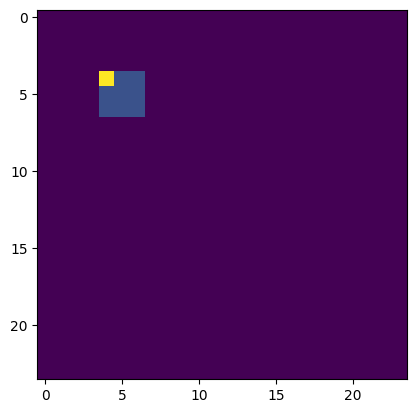

In [8]:
# units position has one TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 1)

plt.imshow(relic_estimator.priori)

p_data = 0.25
[]
post[4][4] = 1.0, self.priori[x][y]=0.25, p_data_given_i=1.0


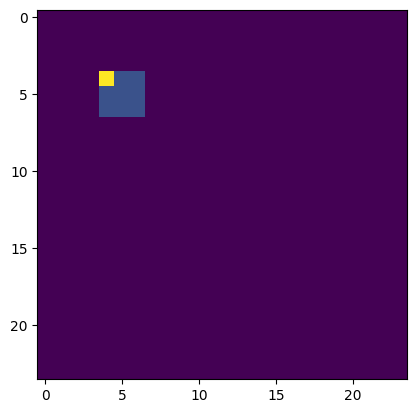

In [9]:
# units position has 2 relic

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 2)

plt.imshow(relic_estimator.priori)

p_data = 0.5625
[array([5, 5])]
post[4][4] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0
[array([4, 4])]
post[5][5] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0


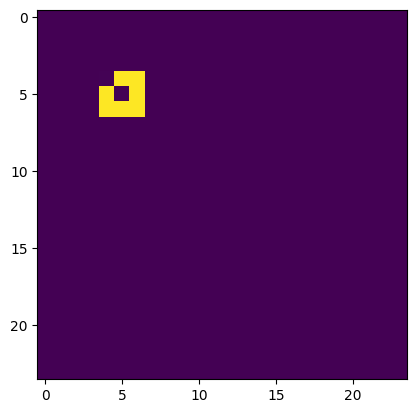

In [10]:
# 2 units positions with 0 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 0)

plt.imshow(relic_estimator.priori)

p_data = 0.375
[array([5, 5])]
post[4][4] = 0.5, self.priori[x][y]=0.25, p_data_given_i=0.75
[array([4, 4])]
post[5][5] = 0.5, self.priori[x][y]=0.25, p_data_given_i=0.75


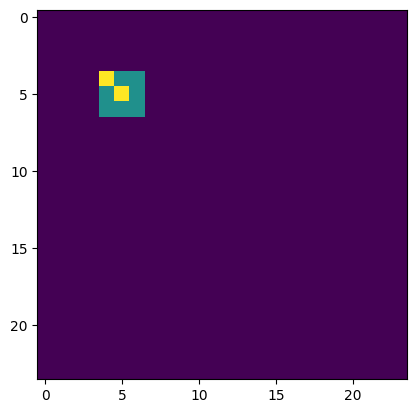

In [11]:
# 2 units positions with 1 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1


relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 1)

plt.imshow(relic_estimator.priori)

p_data = 0.0625
[array([5, 5])]
post[4][4] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.25
[array([4, 4])]
post[5][5] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.25


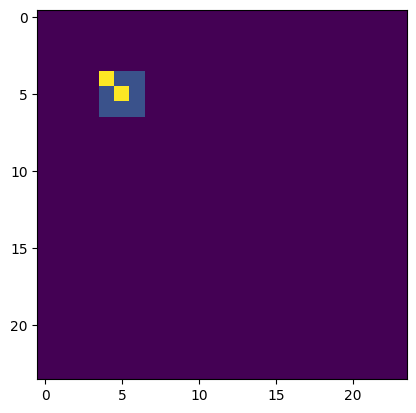

In [12]:
# 2 units positions with 2 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 2)

plt.imshow(relic_estimator.priori)

p_data = 0.421875
[array([5, 5]), array([6, 6])]
post[4][4] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0
[array([4, 4]), array([6, 6])]
post[5][5] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0
[array([4, 4]), array([5, 5])]
post[6][6] = 0.0, self.priori[x][y]=0.25, p_data_given_i=0


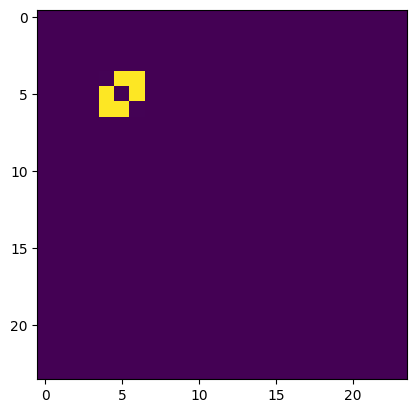

In [13]:
# 2 units positions with 0 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1
units[(6, 6)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 0)

plt.imshow(relic_estimator.priori)

p_data = 0.421875
[array([5, 5]), array([6, 6])]
post[4][4] = 0.3333333333333333, self.priori[x][y]=0.25, p_data_given_i=0.5625
[array([4, 4]), array([6, 6])]
post[5][5] = 0.3333333333333333, self.priori[x][y]=0.25, p_data_given_i=0.5625
[array([4, 4]), array([5, 5])]
post[6][6] = 0.3333333333333333, self.priori[x][y]=0.25, p_data_given_i=0.5625


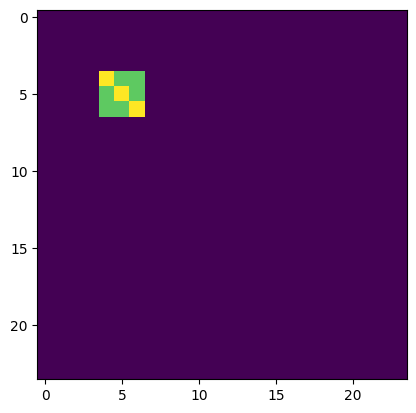

In [14]:
# 3 units positions with 1 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1
units[(6, 6)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 1)

plt.imshow(relic_estimator.priori)

p_data = 0.140625
[array([5, 5]), array([6, 6])]
post[4][4] = 0.6666666666666666, self.priori[x][y]=0.25, p_data_given_i=0.375
[array([4, 4]), array([6, 6])]
post[5][5] = 0.6666666666666666, self.priori[x][y]=0.25, p_data_given_i=0.375
[array([4, 4]), array([5, 5])]
post[6][6] = 0.6666666666666666, self.priori[x][y]=0.25, p_data_given_i=0.375


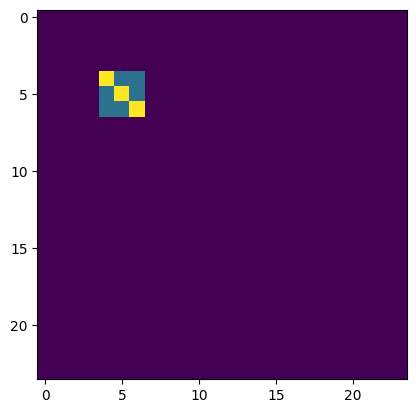

In [15]:
# 3 units positions with 2 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1
units[(6, 6)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 2)

plt.imshow(relic_estimator.priori)

p_data = 0.015625
[array([5, 5]), array([6, 6])]
post[4][4] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625
[array([4, 4]), array([6, 6])]
post[5][5] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625
[array([4, 4]), array([5, 5])]
post[6][6] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625


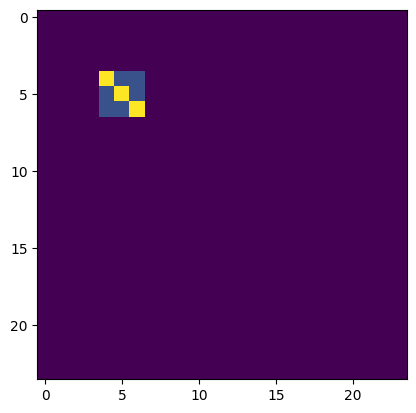

In [16]:
# 3 units positions with 3 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1
units[(6, 6)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 3)

plt.imshow(relic_estimator.priori)

In [17]:
relic_estimator.priori[relic_estimator.priori > 0]

array([0.999, 0.25 , 0.25 , 0.25 , 0.999, 0.25 , 0.25 , 0.25 , 0.999])

p_data = 0.015625
[array([5, 5]), array([6, 6])]
post[4][4] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625
[array([4, 4]), array([6, 6])]
post[5][5] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625
[array([4, 4]), array([5, 5])]
post[6][6] = 1.0, self.priori[x][y]=0.25, p_data_given_i=0.0625


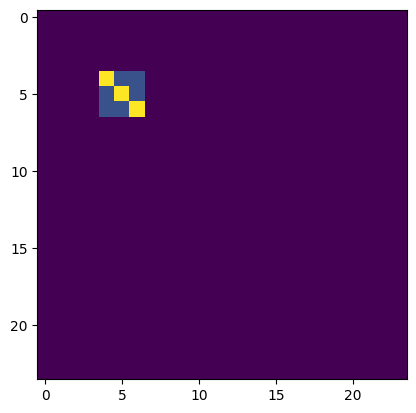

In [18]:
# 3 units positions with 3 TP

units = np.zeros((MAX_WIDTH, MAX_HEIGHT), dtype=bool)
units[(4, 4)] = 1
units[(5, 5)] = 1
units[(6, 6)] = 1

relic_estimator = HiddenRelicNodeEstimator()
relic_estimator.update(mask, units, 3)

plt.imshow(relic_estimator.priori)